In [1]:
import os, glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

plt.style.use('seaborn')
plt.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
pathList = glob.glob('../raw/*')
for idx, p in enumerate(pathList[:4]):
    name = p.split(' ')[-1].split('.')[0]
    print(f'Load {name}')
    if idx < 3:
        globals()[name] = pd.read_csv(p, engine='python')
    else:
        globals()[name] = pd.read_excel(p)

Load mrc_info
Load samp_train
Load samp_cst_feat
Load variable_dtype


# [Power Transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer) & [QuantileTransform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html)
- `문제 제기: 이미 스케일링을 마친 데이터에 사용하면 안 된다.`
    - 스케일링이 끝난 변수를 PT하고 모델링을 위해 스케일링을 다시 하면 변환이 너무 잦아 원래 정보를 손실할 우려가 있다.
    - 그렇다면, 변수의 상태를 먼저 확인해보자

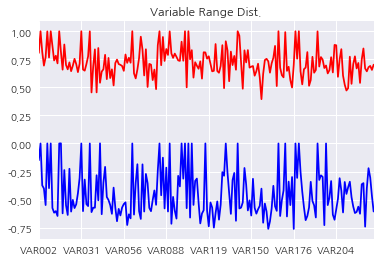

-0.76132 1.0


In [3]:
var_list_num = variable_dtype[variable_dtype['dType']=='numerical']['Variable_Name']
var_list_cate = variable_dtype[variable_dtype['dType']=='categorical']['Variable_Name']

plt.title('Variable Range Dist.')
samp_cst_feat[var_list_num].min().plot(color='blue')
samp_cst_feat[var_list_num].max().plot(color='red')
plt.show()

print(samp_cst_feat[var_list_num].min().min(), samp_cst_feat[var_list_num].max().max())

숫자형 변수는 모두 -1과 1 사이에 존재하는데, 이는 스케일링된 흔적이라고 할 수 있다. 따라서 PT와 QT는 적합하지 않다. 스케일링이 된 변수에 적용 가능한 변환이 필요하다.

# [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer)
- K개의 구간으로 나누어 범주형 자료로 인코딩
- kmeans: Values in each bin have the same nearest center of a 1D k-means cluster.

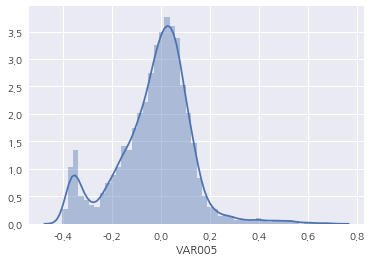

In [4]:
# bimodal case
var_org = samp_cst_feat['VAR005']
sns.distplot(var_org)
plt.show()

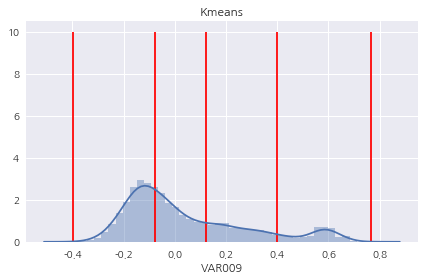

In [5]:
from sklearn.preprocessing import KBinsDiscretizer

var_org = samp_cst_feat['VAR009']
sns.distplot(var_org)
plt.title('Kmeans')

est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
var_est = est.fit_transform(var_org.values.reshape(-1,1))

for i in est.bin_edges_:
    plt.vlines(i, ymin=0, ymax=10, color='red')

plt.tight_layout()
plt.show()

- Common. GMM 개형을 찾아낸다.(재우 파이팅)
- Case 1. Bimodal 형태의 분포를 이루는 경우 N구간으로 나눠 각각 Categorical로 인코딩한다.
- Case 2. 동일한 경우 N구간으로 나눈 중앙값으로 대체한다.

# [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures)
- 독립적인 변수들을 제곱하고 곱하여 교호 작용을 추가하는 방식

In [6]:
var_twin = samp_cst_feat[['VAR002','VAR003']]
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
var_poly = poly.fit_transform(var_twin)
pd.DataFrame(var_poly).head()

,0,1,2,3,4
0,-0.06610,0.5280,0.004369,-0.034901,0.278784
1,-0.09537,0.1347,0.009095,-0.012846,0.018144
2,-0.01048,0.8360,0.000110,-0.008761,0.698896
3,0.05194,0.7505,0.002698,0.038981,0.563250
4,-0.08536,0.3767,0.007286,-0.032155,0.141903
